In [5]:
import glob
import shutil
import SimpleITK as sitk
import numpy as np
import os
import pandas as pd
from collections import Counter
from multiprocessing import Pool
from numpy.lib.npyio import save
from numpy.lib.shape_base import _dstack_dispatcher
from numpy.lib.type_check import imag
from pathlib import Path
import pathlib
import multiprocessing
import math
import functools
from functools import partial
from Utils import *
import pydicom
import re
import scipy.ndimage
import matplotlib.pyplot as plt
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from shutil import copyfile
import json
from tqdm import tqdm
from detect_patient_with_label import extract_labeled_from_dcm_or_nii

In [14]:
original_path='/data/wyh_data/影像数据EGFR1第二部分'
res=get_file(original_path)
temp=filter(lambda x:Path(x).suffix in ['.gz','nii'],res)
temp=filter(lambda x: 'Mask' in x,temp)
labelpath=list(temp)
label=pd.DataFrame(labelpath)
label.to_csv('/home/wyh21/AI_Lung_node/data_processing/label.csv',index=False)


KeyboardInterrupt: 

In [ ]:
label=pd.read_csv('/home/wyh21/AI_Lung_node/data_processing/label.csv')

In [ ]:
#原始文件是dcm的，直接按照后处理流程处理
#原始文件是nii的，转换成dcm处理，尽可能统一代码

#下午看看 直接dcm能不能直接往网络里放，DSB排名1的处理方法，原始数据
#还有他们的分割，检测，标签怎么存，结节cube怎么存

In [ ]:
label

,mask_path,img_type,label_type
0,/data/wyh_data/影像数据EGFR1第二部分/Marked/POSITIVE/r...,dcm,gz
1,/data/wyh_data/影像数据EGFR1第二部分/Marked/POSITIVE/r...,dcm,gz
2,/data/wyh_data/影像数据EGFR1第二部分/Marked/POSITIVE/r...,dcm,gz
3,/data/wyh_data/影像数据EGFR1第二部分/Marked/POSITIVE/r...,dcm,gz
4,/data/wyh_data/影像数据EGFR1第二部分/Marked/POSITIVE/r...,dcm,gz
...,...,...,...
961,/data/wyh_data/影像数据EGFR1第二部分/Marked/POSITIVE/r...,dcm,nii
962,/data/wyh_data/影像数据EGFR1第二部分/Marked/POSITIVE/r...,dcm,nii
963,/data/wyh_data/影像数据EGFR1第二部分/Marked/POSITIVE/r...,dcm,nii
964,/data/wyh_data/影像数据EGFR1第二部分/Marked/POSITIVE/r...,dcm,nii


In [ ]:
#上面是一个搜索标注信息的demo，可以自动扫描设定文件夹下的目录
'''这里顺便记录一下整体的数据描述信息，
1. /data/wyh_data/影像数据EGFR1第二部分/Marked/POSITIVE/3-1marked1/文件目录下的文件，基本上都是病人号文件夹下，影像文件有dcm序列，标注文件一般都是.nii的后缀,也有nii.gz
2. /data/wyh_data/影像数据EGFR1第二部分/Marked/POSITIVE/resistant+non-sensitizing/ 下基本存储的也是病人号文件夹下，影像文件有dcm序列，标注文件一般都是.nii的后缀，部分文件是nii.gz文件
可能需要做一定部分特殊处理
3./data/wyh_data/影像数据EGFR1第二部分/primary_new/EGFR-negative/下的数据一般是以nii.gz作为文件影像信息，数据文件一般是.nii的后缀，标注信息大部分是名称中带有mask的nii文件，注意，标注文件不只一个
'''
#这是基本上所有有标注信息的概览，文件中具有大量的无标签信息，或许是无监督/自监督的点

In [ ]:
patients_path='/home/wyh21/AI_Lung_node/sample_data'

In [ ]:
test_path='/home/wyh21/AI_Lung_node/sample_data/0017565058'

In [4]:
mask_key_path='/home/wyh21/AI_Lung_node/data_processing/label.csv'
mask_key=pd.read_csv(mask_key_path)

In [7]:
temp=open('new_json.json')
bupt=json.load(temp)

In [11]:
nii_img='/home/wyh21/AI_Lung_node/sample_data/0000301739'
dcm_img='/home/wyh21/AI_Lung_node/sample_data/0017552352'

In [90]:
temp=pd.read_csv('/home/wyh21/AI_Lung_node/data_processing/label.csv')
a,b,c=convert_dataframe_to_serveral_list(temp)
compose_info=list(zip(a,b,c))
res=extract_labeled_from_dcm_or_nii(compose_info[400])
b=extract_labeled_from_dcm_or_nii(compose_info[85])#原本存储是正确的，是后面的values多给套了一层列表的括号

In [106]:
c=list(list(b.values())[0])

In [127]:
import SimpleITK as sitk

# Dicom序列所在文件夹路径（在我们的实验中，该文件夹下有多个dcm序列，混合在一起）
file_path = "/home/wyh21/AI_Lung_node/sample_data/0017552352"

# 获取该文件下的所有序列ID，每个序列对应一个ID， 返回的series_IDs为一个列表
series_IDs = sitk.ImageSeriesReader.GetGDCMSeriesIDs(file_path)

# 查看该文件夹下的序列数量
nb_series = len(series_IDs)
print(nb_series)

# 通过ID获取该ID对应的序列所有切片的完整路径， series_IDs[0]代表的是第一个序列的ID
# 如果不添加series_IDs[0]这个参数，则默认获取第一个序列的所有切片路径
series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(file_path, series_IDs[0])

# 新建一个ImageSeriesReader对象
series_reader = sitk.ImageSeriesReader()

# 通过之前获取到的序列的切片路径来读取该序列
series_reader.SetFileNames(series_file_names)

# 获取该序列对应的3D图像
image3D = series_reader.Execute()

# 查看该3D图像的尺寸
#

# 将序列保存为单个的NRRD文件
#
res=sitk.GetArrayFromImage(image3D)


11


In [125]:
dir(sitk.SimpleITK.Image)

['CopyInformation',
 'EraseMetaData',
 'GetBufferAsDouble',
 'GetBufferAsFloat',
 'GetBufferAsInt16',
 'GetBufferAsInt32',
 'GetBufferAsInt64',
 'GetBufferAsInt8',
 'GetBufferAsUInt16',
 'GetBufferAsUInt32',
 'GetBufferAsUInt64',
 'GetBufferAsUInt8',
 'GetDepth',
 'GetDimension',
 'GetDirection',
 'GetHeight',
 'GetITKBase',
 'GetMetaData',
 'GetMetaDataKeys',
 'GetNumberOfComponentsPerPixel',
 'GetNumberOfPixels',
 'GetOrigin',
 'GetPixel',
 'GetPixelID',
 'GetPixelIDTypeAsString',
 'GetPixelIDValue',
 'GetSize',
 'GetSizeOfPixelComponent',
 'GetSpacing',
 'GetWidth',
 'HasMetaDataKey',
 'IsUnique',
 'MakeUnique',
 'SetDirection',
 'SetMetaData',
 'SetOrigin',
 'SetPixel',
 'SetPixelAsComplexFloat64',
 'SetSpacing',
 'TransformContinuousIndexToPhysicalPoint',
 'TransformIndexToPhysicalPoint',
 'TransformPhysicalPointToContinuousIndex',
 'TransformPhysicalPointToIndex',
 '_Image__ipaste',
 '__GetPixelAsComplexFloat32__',
 '__GetPixelAsComplexFloat64__',
 '__GetPixelAsDouble__',
 '__Get

In [36]:
dcm_file=list(list(b.values())[0])
nii_file=list(res.values())[0][0]

def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16), np.array([slices[0].SliceThickness,
 slices[0].PixelSpacing[0], slices[0].PixelSpacing[1]], dtype=np.float32)


In [37]:
res=load_scan(dcm_file)
case_pixels, spacing = get_pixels_hu(res)

In [71]:
Path(nii_file[15:]).parents[0]/'_clean.npy'

PosixPath('影像数据EGFR1第二部分/primary_new/EGFR-negative/6-10_6-10_NIFTI_6-12_6-12_NIFTI/6-10_NIFTI/6-10marked/0000301739/_clean.npy')

In [65]:
def get_pixels_hu_from_nii(nii_path):
    nii=sitk.ReadImage(nii_path)
    nii_img=sitk.GetArrayFromImage(nii)
    return np.array(nii_img, dtype=np.int16), np.array([nii.GetSpacing()[2],nii.GetSpacing()[0],nii.GetSpacing()[1]],dtype=np.float32)


In [47]:
nii_img.shape

(56, 512, 512)

In [27]:
img.shape

(56, 512, 512)

In [40]:
def load_scan(filelist):#只是一个加载slice的函数，不用想的太复杂
    slices = [pydicom.dcmread(s) for s in filelist]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    if slices[0].ImagePositionPatient[2] == slices[1].ImagePositionPatient[2]:
        sec_num = 2
        while slices[0].ImagePositionPatient[2] == slices[sec_num].ImagePositionPatient[2]:
            sec_num = sec_num+1
        slice_num = int(len(slices) / sec_num)
        slices.sort(key = lambda x:float(x.InstanceNumber))
        slices = slices[0:slice_num]
        slices.sort(key = lambda x:float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices


In [12]:
case=load_scan(list(list(b.values())[0]))


In [29]:
test_path='/data/wyh_data/影像数据EGFR1第二部分/Marked/POSITIVE/resistant+non-sensitizing/0007131998'
label_path=glob.glob(os.path.join(test_path,'*.nii'))
series_IDs = sitk.ImageSeriesReader.GetGDCMSeriesIDs(test_path)
for i in range(len(series_IDs)):
        series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(test_path, series_IDs[i])#series_file_names是一个元组，存储了匹配的文件序列
        #print(type(series_file_names))
        series_reader = sitk.ImageSeriesReader()
        series_reader.SetFileNames(series_file_names)
        # 获取该序列对应的3D图像
        image3D = series_reader.Execute()
        if image3D.GetSize()==sitk.ReadImage(label_path).GetSize()[0:3]:
                print(3)
        #print(image3D.GetSize())
        #     data_info[mask_path[i]]=series_file_names

3
3


In [13]:
sitk.ReadImage(label_path).GetSize()

(512, 512, 21, 1)

In [ ]:
mask_key.columns

Index(['mask_path', 'img_type', 'label_type'], dtype='object')

In [ ]:
def convert_dataframe_to_serveral_list(data):
    '''
    外面的变量数必须对得上列的数量才行
    '''
    temp=[]
    for x in data.columns:
        temp.append(data[x].values.tolist())
    return temp

In [ ]:
file_path='/home/wyh21/AI_Lung_node/data_processing/new_json.json'

In [ ]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

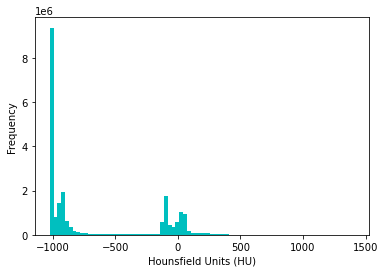

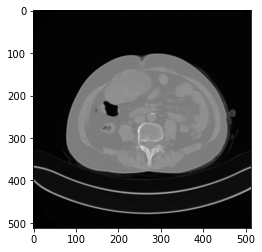

In [77]:
plt.hist(case_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(case_pixels[1], cmap=plt.cm.gray)

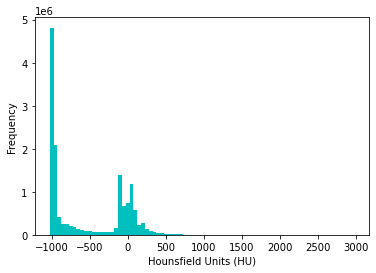

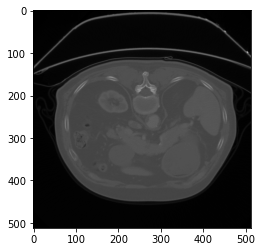

In [75]:

#first_patient_pixels = get_pixels_hu(nii_img)
plt.hist(nii_img.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(nii_img[1], cmap=plt.cm.gray)
plt.show()

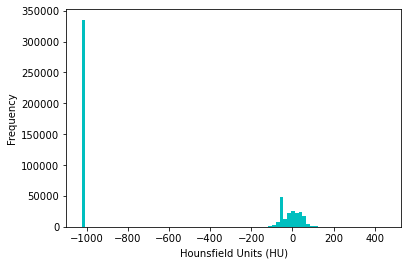

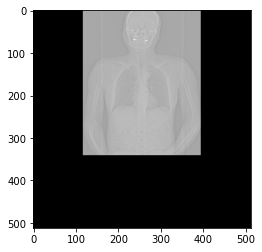

In [129]:
plt.hist(res.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(res[1], cmap=plt.cm.gray)#没进行过hu转换的，所以nii读的方式和dcm不同

In [ ]:
#from Utils import resample
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    #spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)
    pixel_spacing = scan[0].PixelSpacing
    spacing = np.array([scan[0].SliceThickness,float(pixel_spacing[0]), float(pixel_spacing[1])], dtype='float32')


    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

    
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (63, 512, 512)
Shape after resampling	 (315, 307, 307)


In [ ]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    #verts, faces = measure.marching_cubes_classic(p, threshold)
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

/tmp/ipykernel_54707/1528686392.py:8: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold)


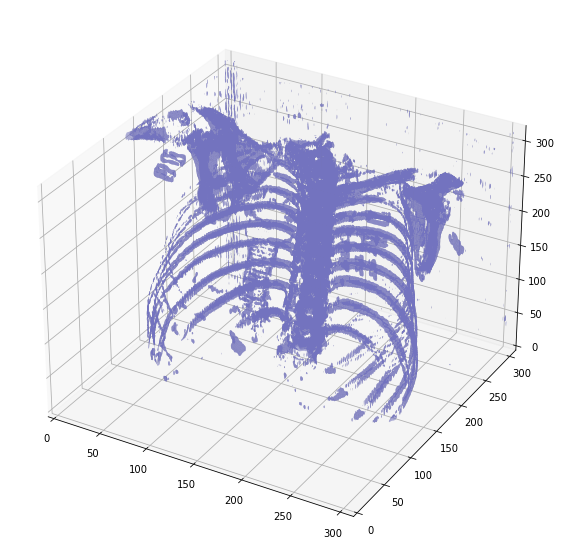

In [ ]:
plot_3d(pix_resampled, 400)#画一次用好几分钟

In [ ]:
print(3)

3


In [ ]:
res

[[1, 3, 4], [5, 6, 6], [4, 5]]

In [ ]:
res=list(res)

In [ ]:
file_list=get_file(data_path)

In [ ]:
import SimpleITK as sitk
import numpy as np
# img_path='F:\\dataset\\pancreas\\Output\\thick\\original\\1'
# mask_path='F:\\dataset\\pancreas\\Output\\thick\\groundtruth\\1'
 
reader = sitk.ImageSeriesReader()
img_names = reader.GetGDCMSeriesFileNames(data_path)
reader.SetFileNames(img_names)
image = reader.Execute()
image_array = sitk.GetArrayFromImage(image) # z, y, x
 
# reader = sitk.ImageSeriesReader()
# mask_names = reader.GetGDCMSeriesFileNames(mask_path)
# reader.SetFileNames(mask_names)
# mask = reader.Execute()
# mask_array = sitk.GetArrayFromImage(mask) # z, y, x

In [ ]:
def make_dataset(DirectoryPath:Path,slice_path_list,mask_path_list,ratio=1.5):
    '''

    '''

    nodule_path=Path(DirectoryPath/"nodule")
    context_nodule_path=Path(DirectoryPath/"context_nodule")
    position_path=Path(DirectoryPath/'point_cloud')
    detection_path=Path(DirectoryPath/'detection')



    for index in range(len(slice_path_list)):
        img_nii = sitk.ReadImage(slice_path_list[index])
        img_array = sitk.GetArrayFromImage(img_nii)

        mask_nii = sitk.ReadImage(mask_path_list[index])
        mask_array = sitk.GetArrayFromImage(mask_nii)

        res=np.where(mask_array==1)#返回的是 x y z 轴,x y z 分别对应不同的轴方向，未必是原来那样的
        valid_z_pathes=list(dict(Counter(res[0])).keys())
        nodule_start=classify_nodule_and_relabel(valid_z_pathes,img_array,mask_array)

        for i in range(1,nodule_start+1):
            zlist, ylist, xlist = np.where(mask_array==i)
            position=np.argwhere(mask_array==1)    
            position=position/np.array(mask_array.shape)[:,None].T#用来对点云坐标数据进行归一化
            #就不存储类别了，因为所有的点云的类别都是肺结节
            position_path=nodule_path/f"position{index}_{i}.npy"
            save_np_array(position,position_path)#保存点云坐标

            xmin,xmax,ymin,ymax,zmin,zmax= xlist[0],xlist[-1],ylist[0],ylist[-1],zlist[0],zlist[-1]
            detection_label=np.array([xmin,xmax,ymin,ymax,zmin,zmax])
            detection_path=detection_path/f"detection{index}_{i}.npy"
            save_np_array(detection_label,detection_path)#保存检测坐标
            
            cropped_nodule = img_array[zmin:zmax+1, ymin:ymax+1, xmin:xmax+1]
            (context_xmin,context_xmax),(context_ymin,context_ymax),(context_zmin,context_zmax)=get_context_nodule_coordinate(xmin,xmax,ymin,ymax,zmin,zmax,ratio)
            cropped_nodule1 = img_array[context_zmin:context_zmax,context_ymin:context_ymax+1,context_xmin:context_xmax+1]

            # todo 3D展示结节
            # todo 存储结节（存储为.nii)
            #print('first saved')
            cropped_nodule_path =nodule_path/ f"nodule{index}_{i}.nii" 
            nodule_img = sitk.GetImageFromArray(cropped_nodule)
            sitk.WriteImage(nodule_img, cropped_nodule_path)

            cropped_nodule_path = context_nodule_path/f"nodule{index}_{i}.nii" 
            nodule_img = sitk.GetImageFromArray(cropped_nodule1)
            sitk.WriteImage(nodule_img, cropped_nodule_path)